# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.214655,False,2.941039
1,-0.004082,False,0.050453
2,0.962410,False,1.414290
3,0.304345,False,1.253008
4,1.400684,True,7.154105
...,...,...,...
995,-0.194272,True,4.938361
996,1.102220,False,1.719023
997,1.031414,True,8.734417
998,-0.154344,True,6.041996


<Axes: xlabel='v0'>

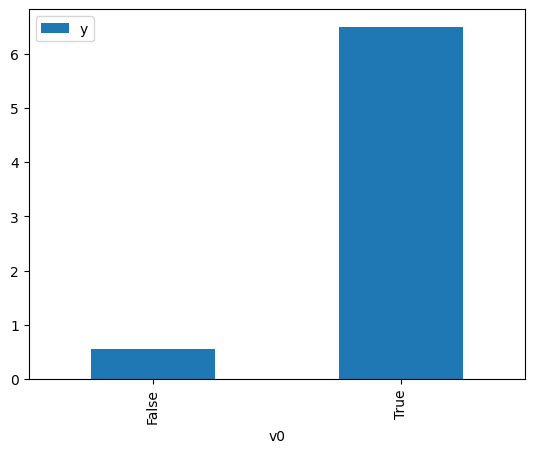

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

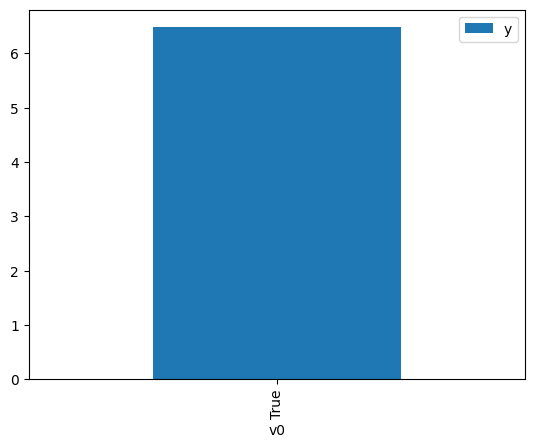

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.288137,False,0.692929,0.381410,2.621849
1,-0.241317,False,-1.478225,0.645138,1.550057
2,0.511788,False,1.506312,0.280834,3.560827
3,0.145289,False,1.833579,0.452189,2.211465
4,0.977713,False,0.280645,0.131029,7.631869
...,...,...,...,...,...
995,0.525273,False,0.768097,0.275305,3.632334
996,0.864292,False,3.000881,0.159729,6.260615
997,-0.556271,False,1.546591,0.775732,1.289105
998,-0.762584,False,-0.901587,0.840549,1.189699


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.289570,True,4.858939,0.619280,1.614778
1,-0.297882,True,5.383500,0.328879,3.040628
2,1.240059,True,8.534554,0.918913,1.088242
3,1.674127,True,8.343734,0.964912,1.036364
4,0.605323,True,5.651376,0.756089,1.322595
...,...,...,...,...,...
995,0.766643,True,6.666703,0.811658,1.232046
996,1.914543,True,7.833458,0.978229,1.022255
997,-0.386300,True,2.690543,0.290320,3.444480
998,0.741430,True,7.903871,0.803660,1.244308


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          2.068e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):                        0.00
Time:                        17:42:53   Log-Likelihood:                         -1410.1
No. Observations:                1000   AIC:                                      2824.
Df Residuals:                     998   BIC:                                      2834.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1873      0.038     58.230      0.000       2.114       2.261
x2             5.0529      0.056     90.582      0.000       4.943       5.162
==============================================================================
Omnibus:                        0.929   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.929
Skew:                           0.074   Prob(JB):                        0.628
Kurtosis:                       2.984   Cond. No.                         2.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""